In [1]:
%load_ext autoreload
%autoreload 2
%pdb

Automatic pdb calling has been turned ON


In [2]:
from dss.env import FashionMNISTEnv 
from dss.transformation import ResNetFeature

import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from torch.utils.data import Dataset
from os import path

/scratch/t.tovi/packages/dss/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
mapping = ResNetFeature(device='cuda')

# Create the RL environment
env = DummyVecEnv([lambda: FashionMNISTEnv()])

Loading precomputed features...


In [4]:
env.envs[0].dataset.features.shape

torch.Size([60000, 784])

In [5]:
# Train the policy using PPO
retrain = False
agent = PPO("MlpPolicy", env, verbose=1)
if path.exists("playground/ppo_fashion_mnist.zip") and not retrain:
    agent = PPO.load("playground/ppo_fashion_mnist.zip", env=env)
else:
    agent.learn(total_timesteps=int(1e5))
    agent.save("playground/ppo_fashion_mnist")

Using cuda device


/scratch/t.tovi/packages/dss/lib/python3.10/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


# Eval

In [6]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import numpy as np

class FlatNet(nn.Module):
    def __init__(self):
        super(FlatNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        return self.fc(x)

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3),
            nn.GELU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3),
            nn.GELU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 5 * 5, 128),
            nn.GELU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        if x.ndim == 3:
            x = x.unsqueeze(1)
        x = self.conv(x)
        x = x.view(-1, 64 * 5 * 5)
        return self.fc(x)

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.fc(x)

class SimpleDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx].squeeze(0), self.y[idx].squeeze(0)

def test_model(model):
    model.eval()
    test_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST(root='./data', train=False, transform=transforms.ToTensor()),
        batch_size=1000, shuffle=False
    )

    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            feature = data
            output = model(feature.to('cuda'))
            pred = output.argmax(dim=1, keepdim=True).to('cpu')
            correct += pred.eq(target.view_as(pred)).sum().item()

    print(f'Test Accuracy: {correct / len(test_loader.dataset) * 100:.2f}%')
    return correct / len(test_loader.dataset)


# Score the dataset

In [7]:
# Create the RL environment
import tqdm

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transforms.ToTensor())

#features = torch.load('playground/features.pt')
#train_dataset = SimpleDataset(features, train_dataset.targets)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

X = []
y = []
data_values = []
for state, label in tqdm.tqdm(train_loader):
    _, log_likelihoods, _ = agent.policy.evaluate_actions(state.to(0), torch.tensor([0, 1]).to(0))
    
    datum_value = log_likelihoods[1].cpu().item()

    X.append(state)
    y.append(label)
    data_values.append(datum_value)

X = torch.cat(X)
y = torch.cat(y)

100%|██████████| 60000/60000 [02:55<00:00, 341.49it/s]


In [8]:
mean_accs = []
eval_runs = 10
for limit in range(1, 11, 2):
    data_size = int(limit/100*len(X))
    epochs = int(100/limit)
    print("Data size: ", data_size)

    indices = np.random.choice(X.shape[0], data_size, replace=False)
    X_subset = X[indices]
    y_subset = y[indices]
    accs = []
    for i in range(eval_runs):
        train_dataset = SimpleDataset(X_subset, y_subset)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

        # Initialize model, optimizer, and environment
        model = ConvNet()
        model.to('cuda')
        optimizer = optim.Adam(model.parameters(), lr=0.01)

        count = 0
        for epoch in range(epochs):
            for data in train_loader:
                image, label = data
                output = model(image.to('cuda'))
                loss = nn.CrossEntropyLoss()(output, label.to('cuda'))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                count += 1
        
        acc = test_model(model)
        accs.append(acc)
    
    mean_accs.append(np.mean(accs))
    print(f'Limit: {limit}, Mean Accuracy: {np.mean(accs):.2f}')


Data size:  600
Test Accuracy: 77.05%
Test Accuracy: 77.86%
Test Accuracy: 78.64%
Test Accuracy: 78.90%
Test Accuracy: 78.36%
Test Accuracy: 78.98%
Test Accuracy: 77.95%
Test Accuracy: 74.45%
Test Accuracy: 77.69%
Test Accuracy: 78.54%
Limit: 1, Mean Accuracy: 0.78
Data size:  1800
Test Accuracy: 79.93%
Test Accuracy: 79.46%
Test Accuracy: 81.61%
Test Accuracy: 79.51%
Test Accuracy: 81.12%
Test Accuracy: 77.76%
Test Accuracy: 79.78%
Test Accuracy: 81.22%
Test Accuracy: 80.93%
Test Accuracy: 81.98%
Limit: 3, Mean Accuracy: 0.80
Data size:  3000
Test Accuracy: 82.64%
Test Accuracy: 81.57%
Test Accuracy: 81.98%
Test Accuracy: 80.35%
Test Accuracy: 83.23%
Test Accuracy: 83.29%
Test Accuracy: 79.03%
Test Accuracy: 81.95%
Test Accuracy: 82.26%
Test Accuracy: 82.44%
Limit: 5, Mean Accuracy: 0.82
Data size:  4200
Test Accuracy: 83.51%
Test Accuracy: 84.17%
Test Accuracy: 82.68%
Test Accuracy: 83.01%
Test Accuracy: 82.62%
Test Accuracy: 82.46%
Test Accuracy: 82.83%
Test Accuracy: 83.08%
Test Ac

# Diversity Score

In [ ]:
# Sort the data by value

X_ = [x for x, _ in sorted(zip(X, data_values), key=lambda x: x[-1], reverse=True)]
y_ = [l for l, _ in sorted(zip(y, data_values), key=lambda x: x[-1], reverse=True)]

len(X_)

60000

In [9]:
X_ = torch.stack(X_)
y_ = torch.stack(y_)

In [ ]:
import math

def dpp(kernel_matrix, max_length, epsilon=1E-10):
    """
    Our proposed fast implementation of the greedy algorithm
    :param kernel_matrix: 2-d array
    :param max_length: positive int
    :param epsilon: small positive scalar
    :return: list
    """
    item_size = kernel_matrix.shape[0]
    cis = np.zeros((max_length, item_size))
    di2s = np.copy(np.diag(kernel_matrix))
    selected_items = list()
    selected_item = np.argmax(di2s)
    selected_items.append(selected_item)
    while len(selected_items) < max_length:
        k = len(selected_items) - 1
        ci_optimal = cis[:k, selected_item]
        di_optimal = math.sqrt(di2s[selected_item])
        elements = kernel_matrix[selected_item, :]
        eis = (elements - np.dot(ci_optimal, cis[:k, :])) / di_optimal
        cis[k, :] = eis
        di2s -= np.square(eis)
        di2s[selected_item] = -np.inf
        selected_item = np.argmax(di2s)
        if di2s[selected_item] < epsilon:
            break
        selected_items.append(selected_item)

    return selected_items

In [11]:
from sklearn.metrics.pairwise import rbf_kernel

F_ = [x.flatten() for x in X_]
F_ = torch.stack(F_)

kernel_matrix = rbf_kernel(F_.cpu().numpy(), gamma=1e-3)

In [13]:
max_size = int(0.51 * len(X_))
selected_indices_ = dpp(kernel_matrix, max_size)

In [23]:
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances

cosine_distances_dpp = []
covariances_dpp = []

size = 600
for i in range(11):
    size_ = size + i * 2850
    samples = F_[selected_indices_[:size_]]
    cosine_distances_dpp.append(np.mean(cosine_distances(samples.cpu().numpy())))
    covariances_dpp.append(torch.diag(torch.cov(samples.T)).sum())

In [14]:
# Greedy DPP 113 minutes

## Trace covariance matrix

In [18]:
cosine_distances_max = []
covariances_max = []

for size in range(1, 52, 5):

    indices = torch.arange(int(size/100*len(X_)))
    samples = X_[indices]
    samples = samples.reshape(samples.shape[0], -1)
    covariances_max.append(torch.diag(torch.cov(samples.T)).sum())
    cosine_distances_max.append(np.mean(cosine_distances(samples.cpu().numpy())))

In [20]:
cosine_distances_min = []
covariances_min = []

for size in range(1, 52, 5):

    indices = -torch.arange(int(size/100*len(X_)))
    samples = X_[indices]
    samples = samples.reshape(samples.shape[0], -1)
    covariances_min.append(torch.diag(torch.cov(samples.T)).sum())
    cosine_distances_min.append(np.mean(cosine_distances(samples.cpu().numpy())))

In [24]:
cosine_distances_random = []
covariances_random = []

for size in range(1, 52, 5):

    indices = np.random.choice(len(X_), int(size/100*len(X_)), replace=False)
    samples = X_[indices]
    samples = samples.reshape(samples.shape[0], -1)
    covariances_random.append(torch.diag(torch.cov(samples.T)).sum())
    cosine_distances_random.append(np.mean(cosine_distances(samples.cpu().numpy())))

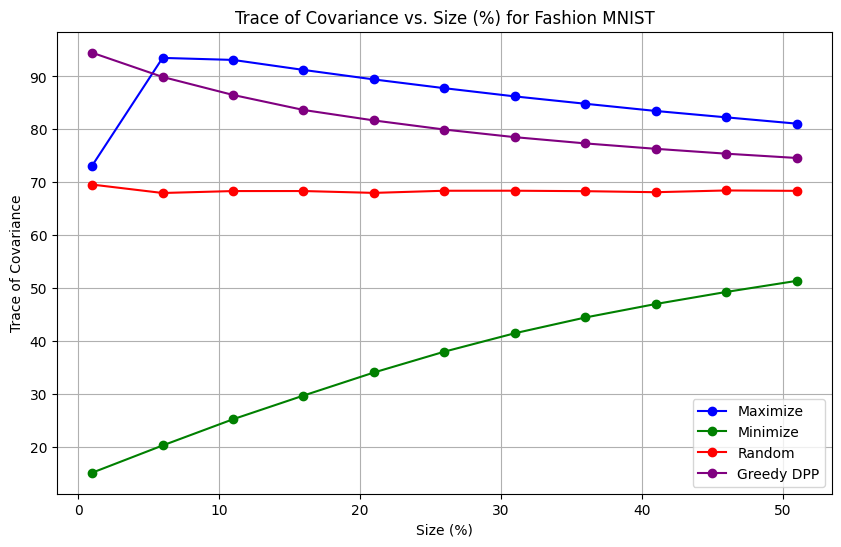

In [25]:
sizes = range(1, 52, 5)

plt.figure(figsize=(10, 6))
plt.plot(sizes, covariances_max, marker='o', linestyle='-', color='b', label='Maximize')
plt.plot(sizes, covariances_min, marker='o', linestyle='-', color='g', label='Minimize')
plt.plot(sizes, covariances_random, marker='o', linestyle='-', color='r', label='Random')
plt.plot(sizes, covariances_dpp, marker='o', linestyle='-', color='purple', label='Greedy DPP')

# Updating labels and title for the plot
plt.xlabel('Size (%)')
plt.ylabel('Trace of Covariance')
plt.title('Trace of Covariance vs. Size (%) for Fashion MNIST')
plt.legend()
plt.grid(True)
plt.show()

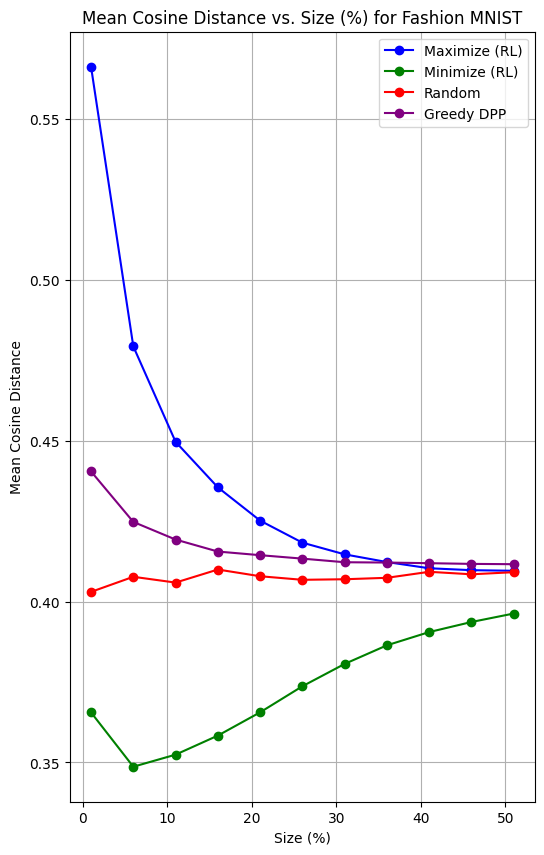

In [28]:
sizes = range(1, 52, 5)

plt.figure(figsize=(6, 10))
plt.plot(sizes, cosine_distances_max, marker='o', linestyle='-', color='b', label='Maximize (RL)')
plt.plot(sizes, cosine_distances_min, marker='o', linestyle='-', color='g', label='Minimize (RL)')
plt.plot(sizes, cosine_distances_random, marker='o', linestyle='-', color='r', label='Random')
plt.plot(sizes, cosine_distances_dpp, marker='o', linestyle='-', color='purple', label='Greedy DPP')

# Updating labels and title for the plot
plt.xlabel('Size (%)')
plt.ylabel('Mean Cosine Distance')
plt.title('Mean Cosine Distance vs. Size (%) for Fashion MNIST')
plt.legend()
plt.grid(True)
plt.show()

# Acc

In [ ]:
X_by_labels = {}
y_by_labels = {}

for label in np.unique(y):
    X_by_labels[label] = [x for x, l in zip(X_, y_) if l == label]
    y_by_labels[label] = [l for l in y_ if l == label]


In [ ]:
X_ = [X_by_labels[i % 10].pop() for i in range(len(X_))]
y_ = [y_by_labels[i % 10].pop() for i in range(len(y_))]

In [ ]:
d_mean_accs = []
eval_runs = 10
for limit in range(1, 22, 5):
    data_size = int(limit/100*len(X))
    epochs = int(100/limit)
    # X_subset = X_[-data_size:]
    # y_subset = y_[-data_size:]

    X_subset = X_[:data_size]
    y_subset = y_[:data_size]

    accs = []
    for i in range(eval_runs):
        train_dataset = SimpleDataset(X_subset, y_subset)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

        # Initialize model, optimizer, and environment
        model = ConvNet()
        model.to('cuda')
        optimizer = optim.Adam(model.parameters(), lr=0.01)

        count = 0
        for epoch in range(epochs):
            for data in train_loader:
                image, label = data
                output = model(image.to('cuda'))
                loss = nn.CrossEntropyLoss()(output, label.to('cuda'))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                count += 1
        
        acc = test_model(model)
        accs.append(acc)
    
    d_mean_accs.append(np.mean(accs))
    print(f'Limit: {limit}, Mean Accuracy: {np.mean(accs):.2f}')


Test Accuracy: 68.10%
Test Accuracy: 65.94%
Test Accuracy: 64.94%
Test Accuracy: 71.59%
Test Accuracy: 60.91%
Test Accuracy: 67.91%
Test Accuracy: 65.09%
Test Accuracy: 65.47%
Test Accuracy: 66.93%
Test Accuracy: 67.09%
Limit: 1, Mean Accuracy: 0.66
Test Accuracy: 70.30%
Test Accuracy: 73.61%
Test Accuracy: 74.55%
Test Accuracy: 75.68%
Test Accuracy: 75.63%
Test Accuracy: 76.66%
Test Accuracy: 78.40%
Test Accuracy: 79.22%
Test Accuracy: 71.78%
Test Accuracy: 68.33%
Limit: 6, Mean Accuracy: 0.74
Test Accuracy: 72.26%
Test Accuracy: 76.03%
Test Accuracy: 80.12%
Test Accuracy: 75.84%
Test Accuracy: 74.35%
Test Accuracy: 77.92%
Test Accuracy: 73.94%
Test Accuracy: 77.63%
Test Accuracy: 71.43%
Test Accuracy: 75.95%
Limit: 11, Mean Accuracy: 0.76
Test Accuracy: 77.68%
Test Accuracy: 77.55%
Test Accuracy: 78.06%
Test Accuracy: 76.61%
Test Accuracy: 77.71%
Test Accuracy: 77.46%
Test Accuracy: 78.83%
Test Accuracy: 74.05%
Test Accuracy: 68.68%
Test Accuracy: 77.15%
Limit: 16, Mean Accuracy: 0.7

In [ ]:
d_mean_accs = []
eval_runs = 10
for limit in range(1, 22, 5):
    data_size = int(limit/100*len(X))
    epochs = int(100/limit)
    X_subset = X_[-data_size:]
    y_subset = y_[-data_size:]

    # X_subset = X_[:data_size]
    # y_subset = y_[:data_size]

    accs = []
    for i in range(eval_runs):
        train_dataset = SimpleDataset(X_subset, y_subset)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

        # Initialize model, optimizer, and environment
        model = ConvNet()
        model.to('cuda')
        optimizer = optim.Adam(model.parameters(), lr=0.01)

        count = 0
        for epoch in range(epochs):
            for data in train_loader:
                image, label = data
                output = model(image.to('cuda'))
                loss = nn.CrossEntropyLoss()(output, label.to('cuda'))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                count += 1
        
        acc = test_model(model)
        accs.append(acc)
    
    d_mean_accs.append(np.mean(accs))
    print(f'Limit: {limit}, Mean Accuracy: {np.mean(accs):.2f}')


Test Accuracy: 57.46%
Test Accuracy: 58.42%
Test Accuracy: 56.93%
Test Accuracy: 59.29%
Test Accuracy: 60.24%
Test Accuracy: 52.15%
Test Accuracy: 54.58%
Test Accuracy: 56.22%
Test Accuracy: 56.36%
Test Accuracy: 54.77%
Limit: 1, Mean Accuracy: 0.57
Test Accuracy: 67.32%
Test Accuracy: 66.86%
Test Accuracy: 69.28%
Test Accuracy: 65.61%
Test Accuracy: 68.37%
Test Accuracy: 64.29%
Test Accuracy: 62.99%
Test Accuracy: 65.54%
Test Accuracy: 67.36%
Test Accuracy: 68.61%
Limit: 6, Mean Accuracy: 0.67
Test Accuracy: 70.98%
Test Accuracy: 69.80%
Test Accuracy: 75.87%
Test Accuracy: 69.19%
Test Accuracy: 74.08%
Test Accuracy: 70.41%
Test Accuracy: 69.50%
Test Accuracy: 74.34%
Test Accuracy: 74.91%
Test Accuracy: 73.72%
Limit: 11, Mean Accuracy: 0.72
Test Accuracy: 77.65%
Test Accuracy: 73.94%
Test Accuracy: 75.75%
Test Accuracy: 70.87%
Test Accuracy: 74.69%
Test Accuracy: 74.68%
Test Accuracy: 75.58%
Test Accuracy: 75.33%
Test Accuracy: 74.27%
Test Accuracy: 77.58%
Limit: 16, Mean Accuracy: 0.7